## Coinsidence detection and sound localisation

### Coinsidence detection

* Coinsidence detection is a mechanism that neurones process simultanious signals that comes from various sources.

### Sound localization

* In the contex of sound localization, coinsidence detection is the brain's way of detecting when same sound arrives for both ears at preciesly the right time difference.

[![Coincidence Detection](https://img.youtube.com/vi/BhAadmwZBmE/0.jpg)](https://www.youtube.com/watch?v=BhAadmwZBmE)

<!-- <iframe width="560" height="315" src="https://www.youtube.com/watch?v=BhAadmwZBmE" frameborder="0" allowfullscreen></iframe> -->

## Model

In here we will construct a simplified model of sound localisation carried out by coinsidence detection and delay lines which are inspired by Jeffress model ([more details](http://www.scholarpedia.org/article/Jeffress_model)). 

If there is a sound coming from particular angle $\theta$, it arrives a one ear earlier than the other ear. This difference is called *interaural time difference* or ITD. we use here a sine wave as the signal, at frequency $f$. So, the time difference is ambiguous and becoms an *interaural phase difference* (IPD). The two are related by, $IPD = 2\pi f. ITD$ 

We use [Brian](https://briansimulator.org/) simulator to do this activity.

In [8]:
try:
    import ipywidgets as widgets
except ImportError:
    widgets = None

try:
    import brian2
except ImportError:
    !pip install brian2

%matplotlib inline
from brian2 import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# prefs.codegen.target = 'numpy'



### Input signal

We'll have the two ears recieve two sine waves with different phase delays, ear 0 will have no delays, and ear 1 will have a delay of `IPD`. Then, we'll have neurons generate spikes as a Poisson process with firing rate `rate_max*0.5*(1+sin(theta))`. We model this in Brian using spike thresold condition `rand()<rate*dt` where `rand()` is a uniform random number in `[0, 1]` and `dt` is the simulation timestep.

interactive(children=(IntSlider(value=100, continuous_update=False, description='rate_max_Hz', step=10), IntSl…

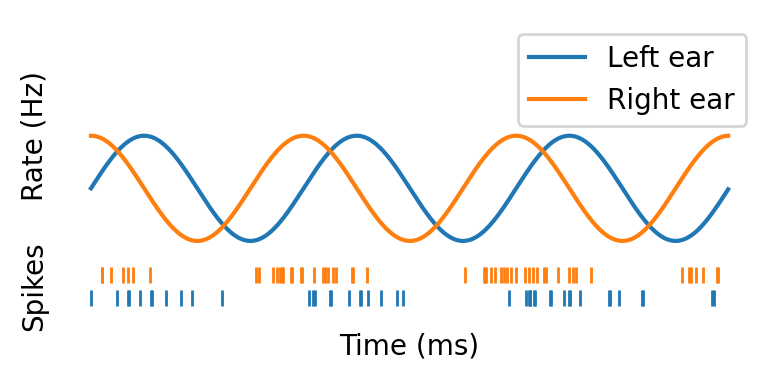

In [12]:
def input_signal(rate_max_Hz=100, ipd_deg=90, f_Hz=3):
    # we cannot use values with units in the widgets, so we add the units first
    rate_max = rate_max_Hz * Hz
    ipd = (pi/180) * ipd_deg  # convert degrees to radians
    f = f_Hz * Hz  # convert frequency to Hz

    '''
    The equations for the ear neurons as follows:
    Use Brian documentation for more details. The `: Hz` at the end of the 
    `rate` equation indicates that the rate is in Hertz, 
    which is a unit of frequency.
    The `: 1` at the end of the `theta` equation indicates that dimensionless.
    Which tells Brian what the units of the variables are.
    The `i` is the index of the neuron, which will be 0 for the neuron 0 and 
    1 for the neuron 1. which allows us to make these two signals different for the two ears.
    '''
    eqs_ears = '''
    theta = 2 * pi * f * t + i * ipd : 1
    rate = rate_max * 0.5 * (1 + sin(theta)) : Hz
    '''
    '''
    We create a group of two neurons with these two equations, that fires a spike 
    according to Poisson process with the given time varing rate. We use a dt of 1ms
    to speed up the simulation. Later we will use better default like 0.1ms.
    '''

    ears = NeuronGroup(2, eqs_ears, threshold='rand() < rate * dt', dt=1*ms)

    # Record the spikes and values of the rate as we run the simulation
    M_spikes = SpikeMonitor(ears)
    M_state = StateMonitor(ears, 'rate', record=True)

    # Run the simulation for 1 second
    run(1 * second)

    # Plot the spikes and the rate
    trains = M_spikes.spike_trains()
    fig = figure(figsize=(4, 2), dpi=200)
    gs = gridspec.GridSpec(2, 1, hspace=0, height_ratios=[1, .3])
    ax = subplot(gs[0])
    plot(M_state.t/ms, M_state.rate[0] / Hz, label='Left ear')
    plot(M_state.t/ms, M_state.rate[1] / Hz, label='Right ear')
    legend(loc='upper right')
    gca().set_frame_on(False)
    ylabel('Rate (Hz)')
    yticks([])
    xticks([])
    ylim(-10, 210)
    subplot(gs[1], sharex=ax)
    plot(trains[0] / ms, [0] * len(trains[0]), '|')
    plot(trains[1] / ms, [1] * len(trains[1]), '|')
    ylim(-1, 2)
    gca().set_frame_on(False)
    xlabel('Time (ms)')
    ylabel('Spikes')
    yticks([])
    xticks([])
    tight_layout()

if widgets is not None:
    widgets.interact(input_signal,
                     rate_max_Hz=widgets.IntSlider(value=100, step=10, continuous_update=False),
                     ipd_deg=widgets.IntSlider(value=90, min=0, max=3600, step=10, continuous_update=False),
                     f_Hz=widgets.FloatSlider(value=3, min=0, max=10, step=1, continuous_update=False))
else:
    input_signal()